In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from flax.serialization import from_bytes
import os
import sys
import jax
import jax.numpy as jnp
import time
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Moves one directory up
sys.path.append(project_root)

from src.model import MiloMLP, CNN
from src.train import create_state_MLP

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"]
    })

device = jax.devices("cpu")[0] #Currently CPU
rng = jax.random.PRNGKey(0)

In [4]:
milo = MiloMLP(
    input_dim=(28, 28), 
    hidden_layer_dim=[(64, 64), (36, 36), (18, 16), (10, 1)],
    output_dim=(10, 1),
    num_channels=1 
)

simpleCNN = CNN()

milo_state_template = create_state_MLP(rng, milo, 0, data_size=(32, 28, 28), device=device)
cnn_state_template = create_state_MLP(rng, simpleCNN, 0, data_size=(32, 28, 28, 1), device=device)

with open("D:\Toolkit\Backup\Personal Projects\milo_net\models\milo_best_state.msgpack", "rb") as f:
    milo_best_state = from_bytes(milo_state_template, f.read())

with open("D:\Toolkit\Backup\Personal Projects\milo_net\models\cnn_best_state.msgpack", "rb") as f:
    cnn_best_state = from_bytes(cnn_state_template, f.read())

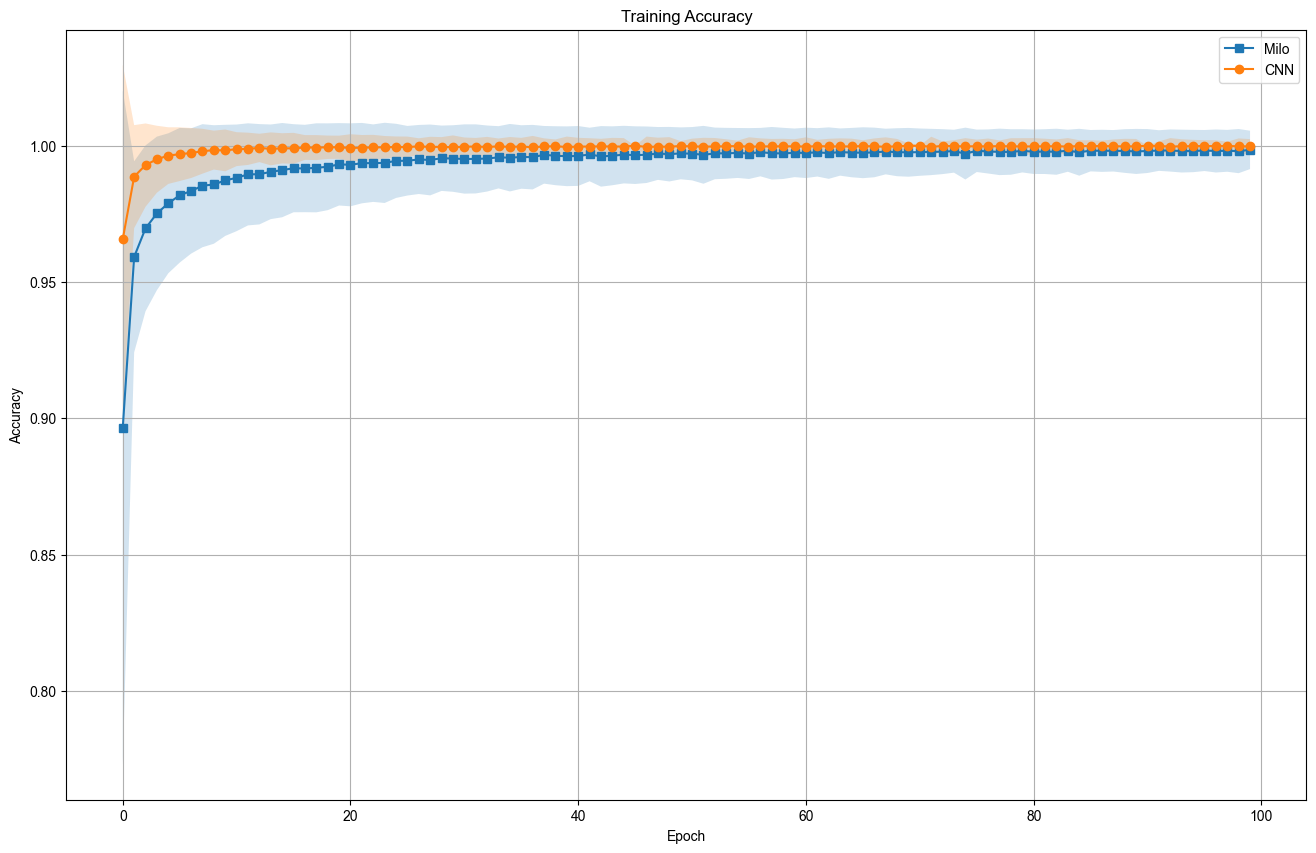

Highest Milo accuracy: 0.9985
Highest CNN accuracy: 1.0000


In [5]:
# --- Load metrics ---
with open("D:\Toolkit\Backup\Personal Projects\milo_net\models\mnist_metrics_history.json", "r") as f:
    metrics = json.load(f)

# --- Accuracy Plot ---
plt.figure(figsize=(16, 10))
plt.plot(metrics['milo_accuracy'], label='Milo', marker = "s")
plt.fill_between(range(len(metrics['milo_accuracy'])),
                 np.array(metrics['milo_accuracy']) - np.array(metrics['milo_accuracy_std']),
                 np.array(metrics['milo_accuracy']) + np.array(metrics['milo_accuracy_std']),
                 alpha=0.2)
plt.plot(metrics['cnn_accuracy'], label='CNN', marker = "o")
plt.fill_between(range(len(metrics['cnn_accuracy'])),
                 np.array(metrics['cnn_accuracy']) - np.array(metrics['cnn_accuracy_std']),
                 np.array(metrics['cnn_accuracy']) + np.array(metrics['cnn_accuracy_std']),
                 alpha=0.2)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

max_milo_accuracy = np.max(metrics['milo_accuracy'])
max_cnn_accuracy = np.max(metrics['cnn_accuracy'])

# Print results
print(f"Highest Milo accuracy: {max_milo_accuracy:.4f}")
print(f"Highest CNN accuracy: {max_cnn_accuracy:.4f}")

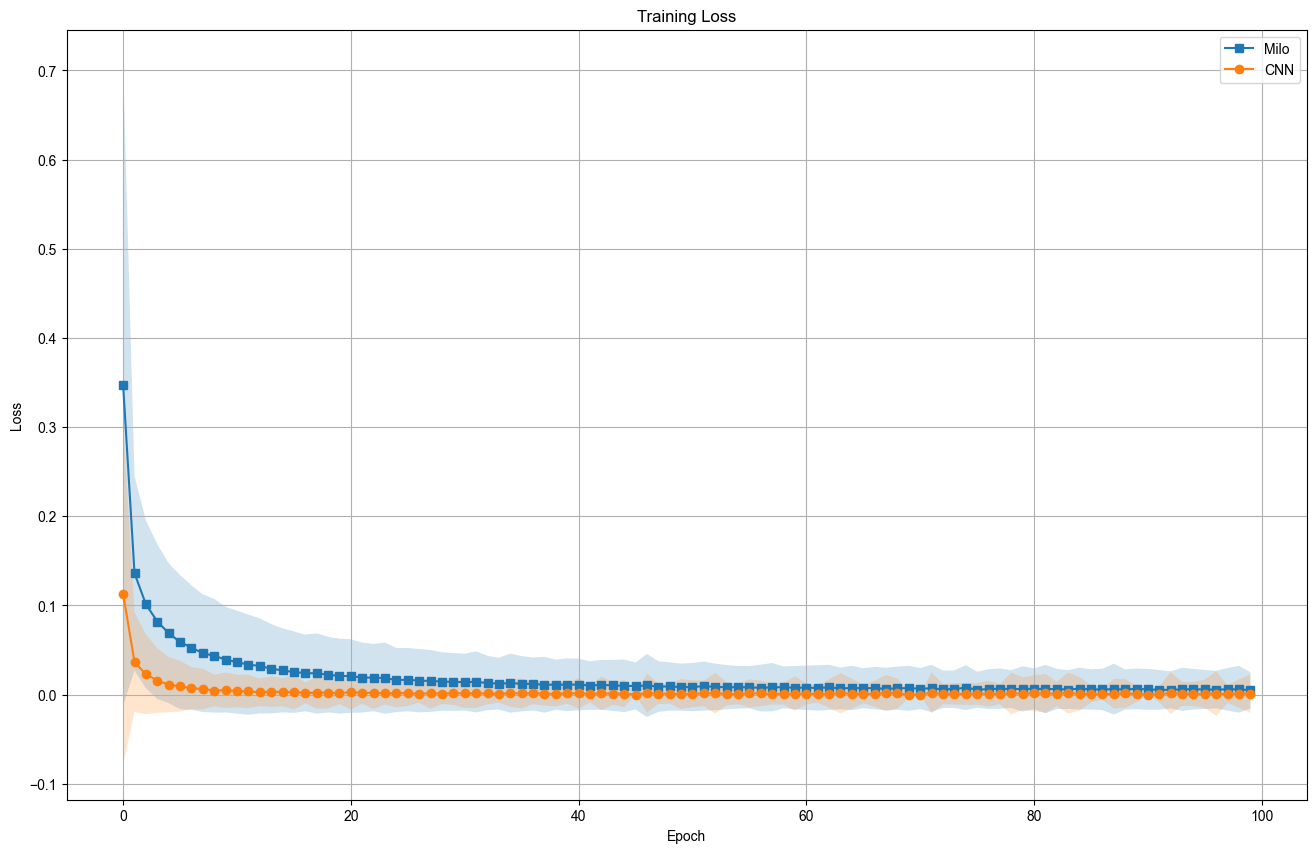

Lowest Milo loss: 0.0049
Lowest CNN loss: 0.0000


In [6]:
plt.figure(figsize=(16, 10))
plt.plot(metrics['milo_loss'], label='Milo', marker = "s")
plt.fill_between(range(len(metrics['milo_loss'])),
                 np.array(metrics['milo_loss']) - np.array(metrics['milo_loss_std']),
                 np.array(metrics['milo_loss']) + np.array(metrics['milo_loss_std']),
                 alpha=0.2)
plt.plot(metrics['cnn_loss'], label='CNN', marker = "o")
plt.fill_between(range(len(metrics['cnn_loss'])),
                 np.array(metrics['cnn_loss']) - np.array(metrics['cnn_loss_std']),
                 np.array(metrics['cnn_loss']) + np.array(metrics['cnn_loss_std']),
                 alpha=0.2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

min_milo_loss = np.min(metrics['milo_loss'])
min_cnn_loss = np.min(metrics['cnn_loss'])

# Print results
print(f"Lowest Milo loss: {min_milo_loss:.4f}")
print(f"Lowest CNN loss: {min_cnn_loss:.4f}")

In [7]:
total_milo_time = sum(metrics['milo_time'])
total_milo_std = np.sqrt(sum(np.array(metrics['milo_time_std'])**2))

total_cnn_time = sum(metrics['cnn_time'])
total_cnn_std = np.sqrt(sum(np.array(metrics['cnn_time_std'])**2))

print(f"Total Milo training time: {total_milo_time:.2f} ± {total_milo_std:.2f} seconds")
print(f"Total CNN training time: {total_cnn_time:.2f} ± {total_cnn_std:.2f} seconds")

Total Milo training time: 0.47 ± 0.05 seconds
Total CNN training time: 2.26 ± 0.07 seconds


In [8]:
from jax.flatten_util import ravel_pytree

# --- Parameter count ---
def count_params(params):
    flat_params, _ = ravel_pytree(params)
    return flat_params.shape[0]

print(f"Milo params: {count_params(milo_best_state.params):,}")
print(f"CNN params:  {count_params(cnn_best_state.params):,}")

Milo params: 15,413
CNN params:  421,642


In [9]:
milo_size_mb = os.path.getsize("D:\Toolkit\Backup\Personal Projects\milo_net\models\milo_best_state.msgpack") / (1024**2)
cnn_size_mb = os.path.getsize("D:\Toolkit\Backup\Personal Projects\milo_net\models\cnn_best_state.msgpack") / (1024**2)

print(f"Milo model size: {milo_size_mb:.2f} MB")
print(f"CNN model size:  {cnn_size_mb:.2f} MB")

Milo model size: 0.18 MB
CNN model size:  4.83 MB


In [10]:
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

test_ds = test_ds.map(
  lambda sample: {
    'image': tf.squeeze(tf.cast(sample['image'], tf.float32) / 255, -1),
    'label': sample['label'],
  }
)

test_ds = test_ds.batch(32)

In [11]:
def benchmark_inference(apply_fn, params, image_batch):
    image_batch = jnp.array(image_batch)
    variables = {'params': params}

    # Warm-up
    apply_fn(variables, image_batch)
    jax.block_until_ready(apply_fn(variables, image_batch))

    start = time.time()
    apply_fn(variables, image_batch)
    jax.block_until_ready(apply_fn(variables, image_batch))
    end = time.time()

    return (end - start) / len(image_batch)

In [12]:
cnn_infer_times = []; milo_infer_times = []
for batch in test_ds:
    batch_cnn = {'image': batch["image"][..., None], 'label': batch["label"]}
    cnn_infer_time  = benchmark_inference(cnn_best_state.apply_fn, cnn_best_state.params, batch_cnn['image'])
    milo_infer_time = benchmark_inference(milo_best_state.apply_fn, milo_best_state.params, batch["image"])

    cnn_infer_times.append(cnn_infer_time)
    milo_infer_times.append(milo_infer_time)

cnn_avg_time = np.mean(cnn_infer_times)
cnn_std_time = np.std(cnn_infer_times)

milo_avg_time = np.mean(milo_infer_times)
milo_std_time = np.std(milo_infer_times)

print(f"CNN average inference time:  {cnn_avg_time * 1e3:.3f} ms/image ± {cnn_std_time * 1e3:.3f} ms")
print(f"Milo average inference time: {milo_avg_time * 1e3:.3f} ms/image ± {milo_std_time * 1e3:.3f} ms")

CNN average inference time:  2.513 ms/image ± 0.621 ms
Milo average inference time: 2.786 ms/image ± 0.899 ms


In [13]:
def get_preds_and_labels(state, test_ds, add_channel=False):
    all_preds = []
    all_labels = []

    for batch in test_ds:
        if add_channel:
            batch['image'] = batch['image'][..., None]

        logits = state.apply_fn({'params': state.params}, np.array(batch['image']))
        if not add_channel:
            logits = logits.squeeze(-1)
        preds = np.argmax(np.array(logits), axis=-1)

        labels = np.array(batch['label'])

        preds = preds.astype(np.int32).flatten()
        labels = labels.astype(np.int32).flatten()

        all_preds.append(preds)
        all_labels.append(labels)

    return np.concatenate(all_preds), np.concatenate(all_labels)


def plot_cm(ax, cm, title):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax.set_title(title)
    tick_marks = np.arange(10)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # Cell labels
    for i in range(10):
        for j in range(10):
            val = cm[i, j]
            ax.text(j, i, f"{val:.2f}",
                    ha="center", va="center",
                    color="white" if val > 0.5 else "black")

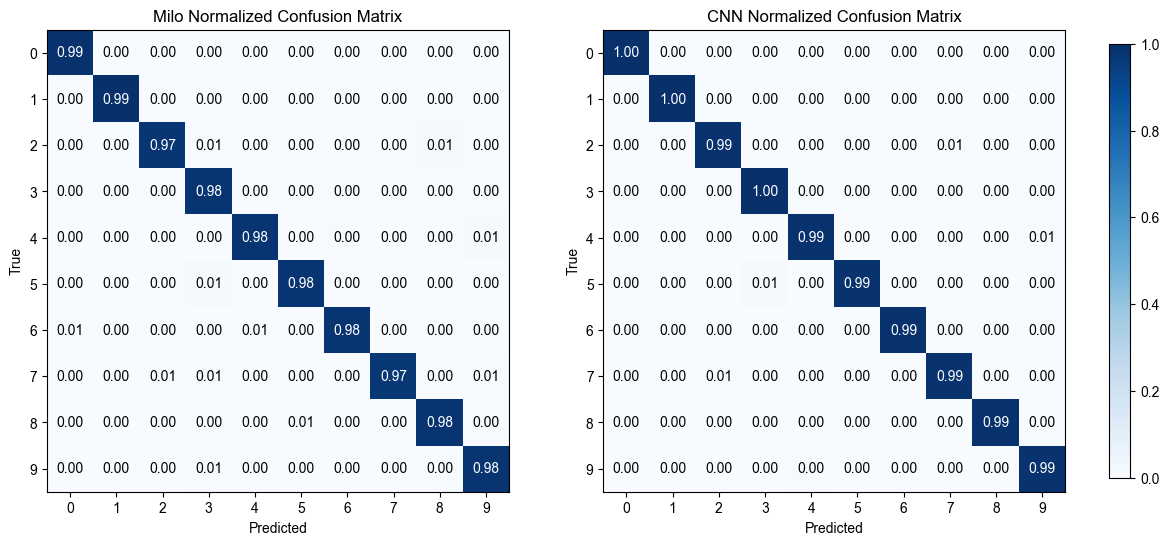

In [14]:
# Get predictions
milo_preds, milo_labels = get_preds_and_labels(milo_best_state, test_ds, add_channel=False)
cnn_preds, cnn_labels   = get_preds_and_labels(cnn_best_state, test_ds, add_channel=True)

# Compute normalized confusion matrices
def normalize_cm(cm):
    return cm.astype('float') / cm.sum(axis=1, keepdims=True)

milo_cm = normalize_cm(confusion_matrix(milo_labels, milo_preds))
cnn_cm  = normalize_cm(confusion_matrix(cnn_labels, cnn_preds))

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot both confusion matrices
plot_cm(axes[0], milo_cm, "Milo Normalized Confusion Matrix")
plot_cm(axes[1], cnn_cm, "CNN Normalized Confusion Matrix")

# Add colorbar
fig.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()